In [14]:
# === IMPORTS ===
SRC_DIR = '../../../src'
DATA_DIR = '/lv_scratch/scratch/graffc0/fire_prediction/data'
DATA_DIR2 = '/extra/graffc0/fire_prediction/data'


# --- System imports
import numpy as np
import os
import sys
import datetime as dt
import xarray as xr
import pandas as pd

from matplotlib import pyplot as plt
from tabulate import tabulate
from matplotlib import gridspec

# --- Package imports
src_path = os.path.abspath(os.path.join(SRC_DIR))
if src_path not in sys.path:
    sys.path.append(src_path)
    
import evaluation.evaluate_model as evm
import evaluation.model_configs as model
import helper.loaders as load
import visualization.plotting as vplt
import visualization.mapping as vmap
import evaluation.setup_data_structs as setup_ds
import evaluation.metrics as metrics
import helper.multidata_wrapper as mdw

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

In [3]:
# Days to predict
T_K_MAX = 5
T_K_ARR = np.arange(1,T_K_MAX+1)

# Years to use
YEAR_START, YEAR_END = 2007, 2016
YEARS_ARR = np.arange(YEAR_START, YEAR_END+1)

# === DATA FILES ===
ignition_cube_src = os.path.join(DATA_DIR, 'interim/modis/fire_cube/fire_ignition_cube_modis_alaska_2007-2016.pkl')
detection_cube_src = os.path.join(DATA_DIR, 'interim/modis/fire_cube/fire_detection_cube_modis_alaska_2007-2016.pkl')
weather_proc_region_src = os.path.join(DATA_DIR, 'interim/gfs/weather_proc/4/weather_proc_gfs_4_alaska_2007-2016.pkl')
weather_proc_region_nw_src = os.path.join(DATA_DIR, 'interim/gfs/grid/4/')
land_cover_src = os.path.join(DATA_DIR, 'interim/land_cover/land_cover_alaska.pkl')

X_grid_nw_interp_src = [os.path.join('/lv_scratch/scratch/graffc0/fire_prediction/data/', 'processed/grid/grid_ds_gfs_4_modis_alaska_2007-01-01_2016-12-31_integrate_interp_10y_10x_5a_%dk.nc') % k for k in T_K_ARR] 

# Build list of file names (based on t_k)
#integrated_cluster_df_fmt = 'processed/fire_weather/fire_weather_integrated_gfs_4_modis_5km_10days_forwards_1400_%dk_alaska_2007-2016.pkl'
#integrated_cluster_df_fmt = 'interim/integrated/fire_weather/fire_weather_integrated_gfs_4_modis_5km_10days_1400_%dk_alaska_2007-2016.pkl'
integrated_cluster_df_fmt = 'interim/integrated/fire_weather/fire_weather_integrated_gfs_4_modis_5km_10days_forwards_day_cents_1400_%dk_alaska_2007-2016.pkl'
integrated_cluster_df_src_list = map(lambda k: (k, os.path.join(DATA_DIR, integrated_cluster_df_fmt % k)), T_K_ARR)

In [4]:
def filter_fire_season(ds, start=(5,14), end=(8,31), years=range(2007,2017)):
    dates = ds.time.values
    ind = np.zeros(dates.shape, dtype=np.bool)
    for year in years:
        start_date = np.datetime64(dt.date(year, start[0], start[1]))
        end_date = np.datetime64(dt.date(year, end[0], end[1]))
        ind = ind | ((dates>=start_date) & (dates<=end_date))
        
    data_vars = {}
    for k in ds.data_vars.keys():
        data_vars[k] = (('y','x','time'), np.array(ds[k].values)[:,:,ind], ds[k].attrs)
        
    new_ds = xr.Dataset(data_vars, coords={'time': ds.time.values[ind]}, attrs=ds.attrs)
    
    return new_ds

In [5]:
# === DATA LOADING ===
#X_ignition_c, Y_detection_c = evm.setup_ignition_data(ignition_cube_src, detection_cube_src)
#weather_proc_region = load.load_pickle(weather_proc_region_src)
#land_cover = load.load_pickle(land_cover_src)
#X_active_df = evm.setup_multiple_active_fire_data(integrated_cluster_df_src_list)
X_grid_interp_nw = {k+1: filter_fire_season(xr.open_dataset(file_path)) for (k,file_path) in enumerate(X_grid_nw_interp_src)}

BOUNDING_BOX = weather_proc_region.bounding_box

FileNotFoundError: [Errno 2] No such file or directory: b'/lv_scratch/scratch/graffc0/fire_prediction/data/processed/grid/grid_ds_gfs_4_modis_alaska_2007-01-01_2016-12-31_integrate_interp_10y_10x_5a_1k.nc'

In [10]:
reload(setup_ds)

YEARS_TRAIN = [2007,2008,2009,2010, 2011, 2012, 2013, 2014, 2015, 2016]
YEARS_TEST = [2007,2008,2009,2010, 2011, 2012, 2013, 2014, 2015, 2016]
T_K_ARR = np.arange(1,T_K_MAX+1)

y_grid_dict = setup_ds.build_y(Y_detection_c, T_K_ARR, YEARS_TRAIN)
X_active_dict = setup_ds.build_x_active(X_active_df, T_K_ARR, YEARS_TRAIN)
X_grid_dict = setup_ds.build_x_grid(weather_proc_region, Y_detection_c, land_cover, T_K_ARR, 15, 15, [2,5,10], [.25, .5, .75], [5,10,15], YEARS_TRAIN)


T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


In [5]:
X_grid_dict_interp_nw = {k: mdw.MultidataWrapper((ds,ds)) for (k,ds) in X_grid_interp_nw.items()}

In [6]:
%%capture
setup_ds.add_region_biases(X_grid_dict, 11)
setup_ds.add_water_mask(X_grid_dict, weather_proc_region.bounding_box)

In [7]:
param_dict = {'None': [],
              'Temp/Humid': ['temperature', 'humidity'],
              'All': ['temperature','humidity','wind','rain']}

param_dict_grid = {'None': [],
              'Temp/Humid': ['temperature', 'humidity'],
              'All': ['temperature','humidity','wind','rain'],
            }             

In [25]:
# Test baselines
results_no_ig, models_no_ig = evm.evaluate_model_params(lambda x: model.no_ignition_model_poisson(x, BOUNDING_BOX), param_dict, X_active_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

 T_k=1


In [12]:
results_active_only_grid, models_active_only_grid = evm.evaluate_model_params(model.active_only_grid_model_poisson, param_dict_grid, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

 T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


In [41]:
results_active_only_grid_nw, models_active_only_grid_nw = evm.evaluate_model_params(model.active_only_grid_model_poisson, {'All': ['temperature', 'humidity', 'wind', 'rain']}, X_grid_dict_nw, y_grid_dict, YEARS_TEST, [1])

NameError: name 'X_grid_dict_nw' is not defined

In [58]:
results_active_only_grid_interp_nw, models_active_only_grid_interp_nw = evm.evaluate_model_params(model.active_only_grid_model_poisson, param_dict_grid, X_grid_dict_interp_nw, y_grid_dict, YEARS_TEST, T_K_ARR)

T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


In [ ]:
def generate_calibration_plot(results):
    pass

In [45]:
metrics_ = [metrics.root_mean_squared_error]

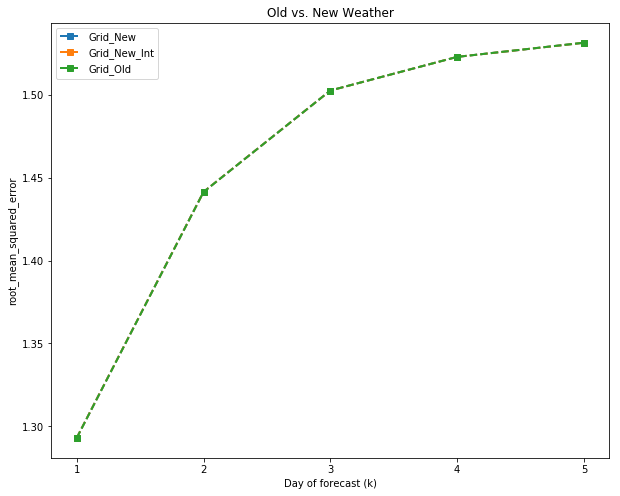

In [59]:
grid_max = {'Grid_Old': results_active_only_grid[1]['None'], 'Grid_New': results_active_only_grid_nw[1]['None'],
           'Grid_New_Int': results_active_only_grid_interp_nw[1]['None']}
grid_max = vplt.plot_results_grid([(grid_max, 'Old vs. New Weather')], T_K_ARR, metrics_)

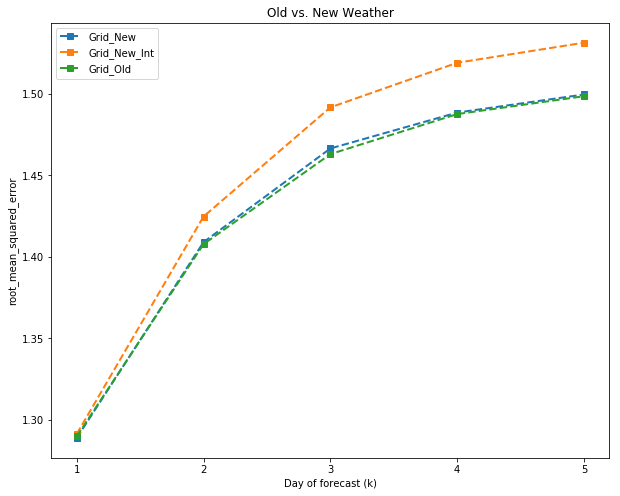

In [60]:
grid_max = {'Grid_Old': results_active_only_grid[1]['Temp/Humid'], 'Grid_New': results_active_only_grid_nw[1]['Temp/Humid'],
           'Grid_New_Int': results_active_only_grid_interp_nw[1]['Temp/Humid']}
grid_max = vplt.plot_results_grid([(grid_max, 'Old vs. New Weather')], T_K_ARR, metrics_)

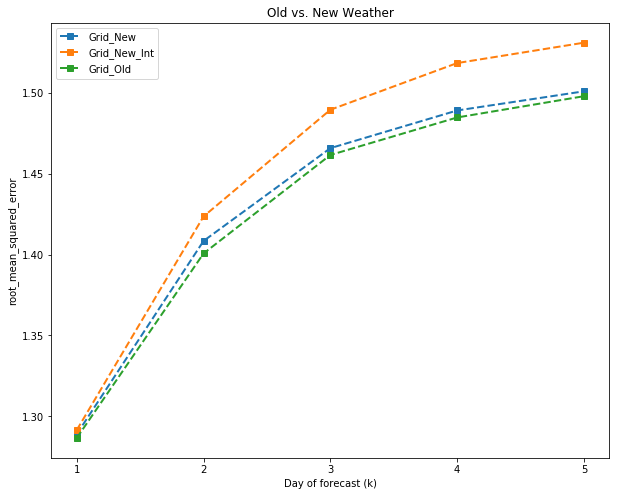

In [63]:
grid_max = {'Grid_Old': results_active_only_grid[1]['All'], 'Grid_New': results_active_only_grid_nw[1]['All'],
           'Grid_New_Int': results_active_only_grid_interp_nw[1]['All']}
grid_max = vplt.plot_results_grid([(grid_max, 'Old vs. New Weather')], T_K_ARR, metrics_)

In [16]:
temp = np.mean(X_grid_dict[1][0].temperature, axis=(0,1))
temp_int = np.mean(X_grid_dict_interp_nw[1][0].temperature, axis=(0,1))

In [18]:
humid = np.mean(X_grid_dict[1][0].humidity, axis=(0,1))
humid_int = np.mean(X_grid_dict_interp_nw[1][0].humidity, axis=(0,1))

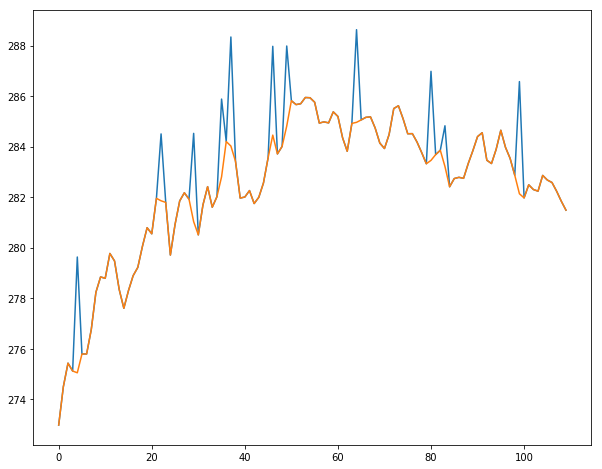

In [17]:
plt.plot(temp[:110])
plt.plot(temp_int[:110])

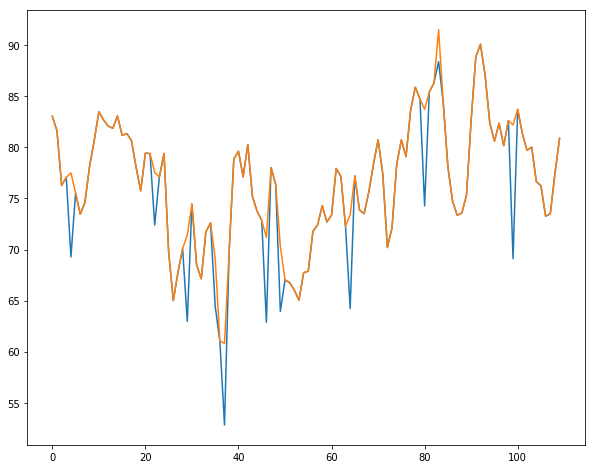

In [19]:
plt.plot(humid[:110])
plt.plot(humid_int[:110])

In [91]:
start = X_grid_dict[1][0].time[-110]
end = X_grid_dict[1][0].time[-1]
print start, end

<xarray.DataArray 'time' ()>
array('2016-05-14T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2016-05-14 <xarray.DataArray 'time' ()>
array('2016-08-31T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2016-08-31


In [16]:
import pickle
fn = 'interim/gfs/weather_proc/4/weather_proc_gfs_4_alaska_2007-2016.pkl'
with open(os.path.join(DATA_DIR2,fn), 'rb') as fin:
    data = pd.read_pickle(fin)

In [6]:
fn = 'interim/gfs/region/4/gfs_4_alaska_20070101_20161231.nc'
ds_4 = xr.open_dataset(os.path.join(DATA_DIR, fn))

In [11]:
fn = 'interim/gfs/region/3/gfs_3_alaska_20070101_20161231.nc'
ds_3 = xr.open_dataset(os.path.join(DATA_DIR, fn))

In [12]:
fn = 'interim/gfs/filled/gfs_4_alaska_20070101_20161231_integrate_interp.nc'
ds_4_interp = xr.open_dataset(os.path.join(DATA_DIR, fn))

In [7]:
fn = 'interim/gfs/grid/gfs_4_alaska_20070101_20161231_integrate_interp_grid.nc'
ds_4_grid_interp = xr.open_dataset(os.path.join(DATA_DIR, fn))

In [8]:
ds_temp = np.array(ds_4.temperature)
ds_humid = np.array(ds_4.humidity)
ds_precip = np.array(ds_4.precipitation)

In [9]:
ds_4_grid_temp = np.array(ds_4_grid_interp.temperature)
ds_4_grid_humid = np.array(ds_4_grid_interp.humidity)
ds_4_grid_wind = np.array(ds_4_grid_interp.wind_speed)
ds_4_grid_precip = np.array(ds_4_grid_interp.precipitation_24hr)

In [28]:
time_ind = np.array(list(map(lambda x: x.year, data.dates)))==2007

In [26]:
ds_4_grid_temp.shape

(14612, 33, 55)

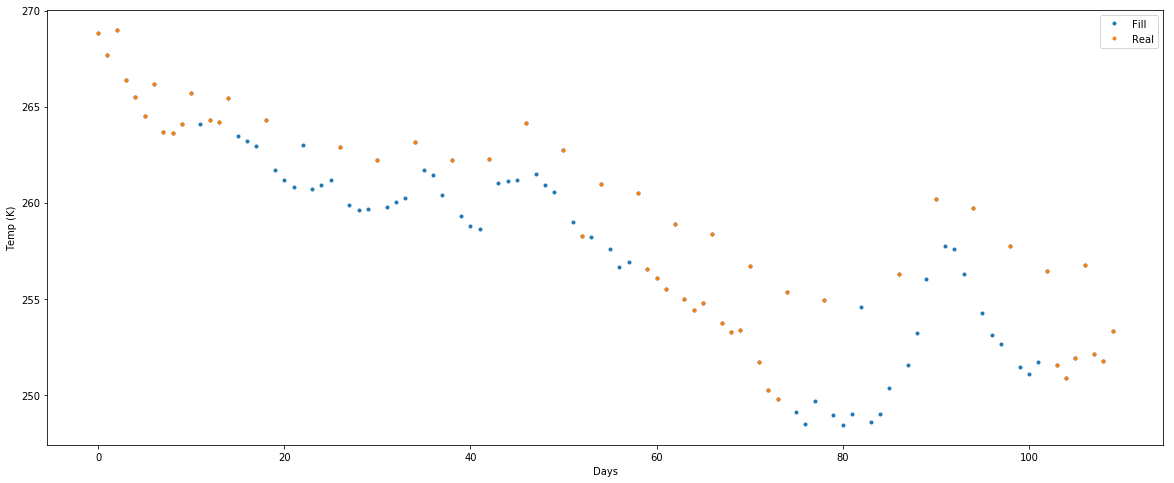

In [34]:
plt.rcParams['figure.figsize'] = [20, 8]
fill = np.mean(ds_4_grid_temp[time_ind], axis=(1,2))
plt.plot(fill[134:244], '.', label='Fill')
real = np.mean(data['temperature'].values[:,:,time_ind], axis=(0,1))
plt.plot(real[134:244], '.', label='Real')

plt.ylabel('Temp (K)')
plt.xlabel('Days')
plt.legend()

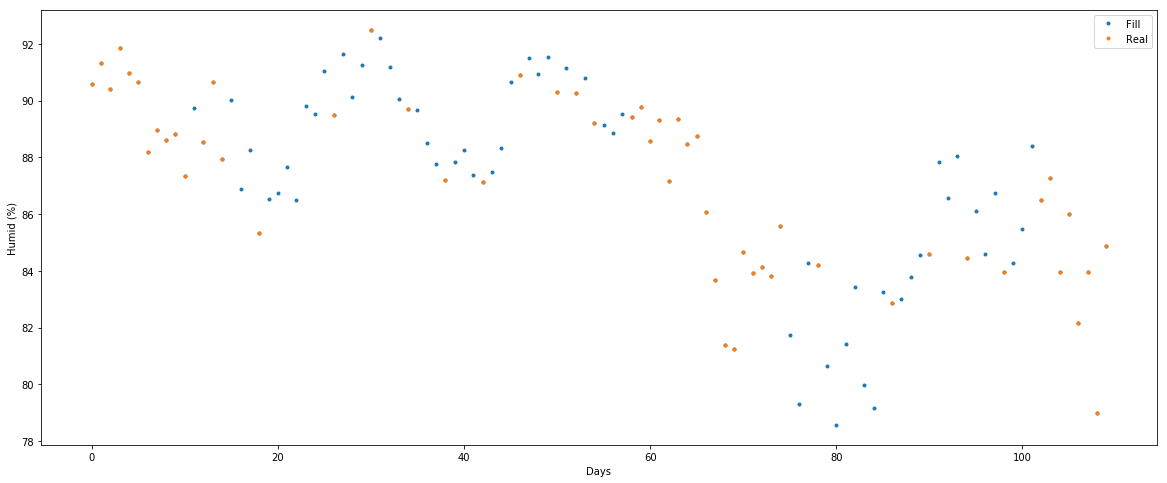

In [36]:
plt.rcParams['figure.figsize'] = [20, 8]
fill = np.mean(ds_4_grid_humid[time_ind], axis=(1,2))
plt.plot(fill[134:244], '.', label='Fill')
real = np.mean(data['humidity'].values[:,:,time_ind], axis=(0,1))
plt.plot(real[134:244], '.', label='Real')

plt.ylabel('Humid (%)')
plt.xlabel('Days')
plt.legend()

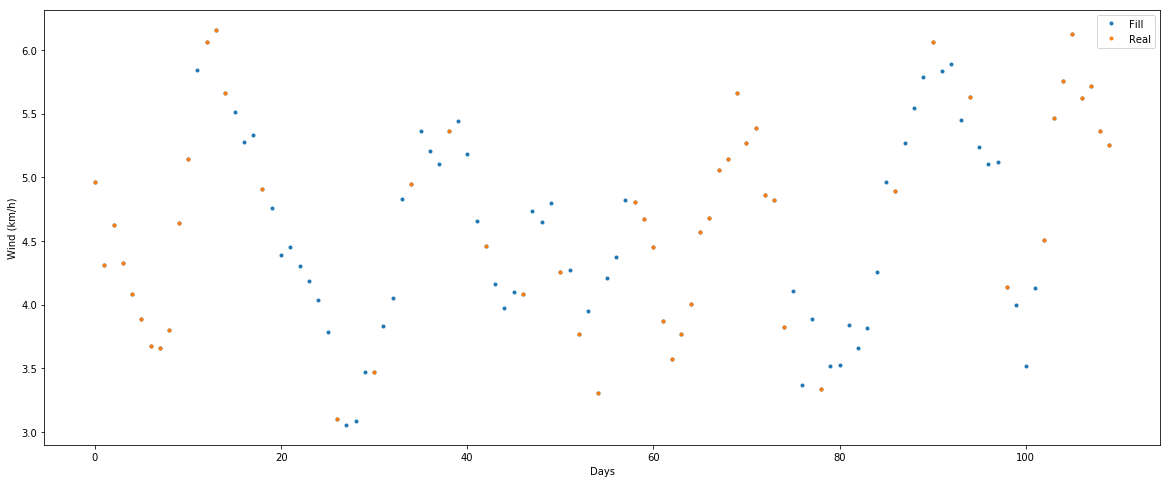

In [37]:
plt.rcParams['figure.figsize'] = [20, 8]
fill = np.mean(ds_4_grid_wind[time_ind], axis=(1,2))
plt.plot(fill[134:244], '.', label='Fill')
real = np.mean(data['wind'].values[:,:,time_ind], axis=(0,1))
plt.plot(real[134:244], '.', label='Real')

plt.ylabel('Wind (km/h)')
plt.xlabel('Days')
plt.legend()

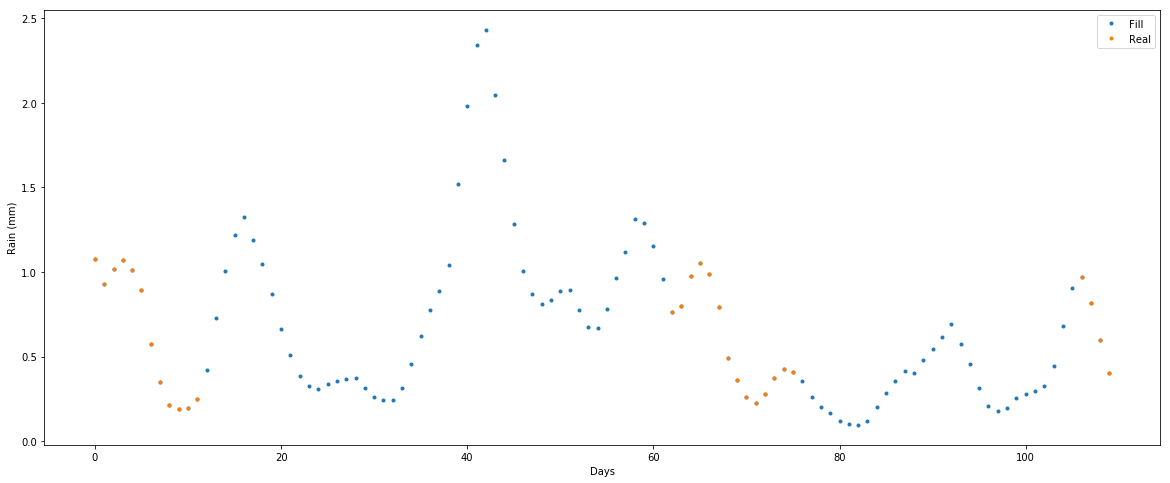

In [38]:
plt.rcParams['figure.figsize'] = [20, 8]
fill = np.mean(ds_4_grid_precip[time_ind], axis=(1,2))
plt.plot(fill[134:244], '.', label='Fill')
real = np.mean(data['rain'].values[:,:,time_ind], axis=(0,1))
plt.plot(real[134:244], '.', label='Real')

plt.ylabel('Rain (mm)')
plt.xlabel('Days')
plt.legend()

In [ ]:
plt.plot(humid[:110])
plt.plot(humid_int[:110])

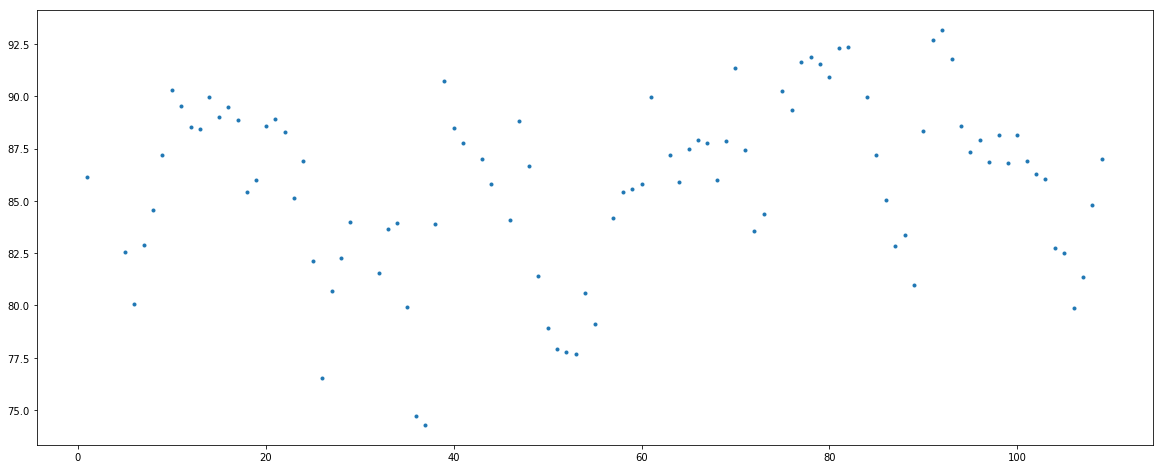

In [144]:
fill = np.mean(ds_humid[::3][time_ind][2::4][134:244], axis=(1,2))
plt.plot(fill, '.', label='Fill')

In [ ]:
df

In [53]:
ds_temp_fill = np.array(ds3.temperature)[::3]
ds_humid_fill = np.array(ds3.humidity)[::3]
ds_precip_fill = np.array(ds3.precipitation)[2::3]

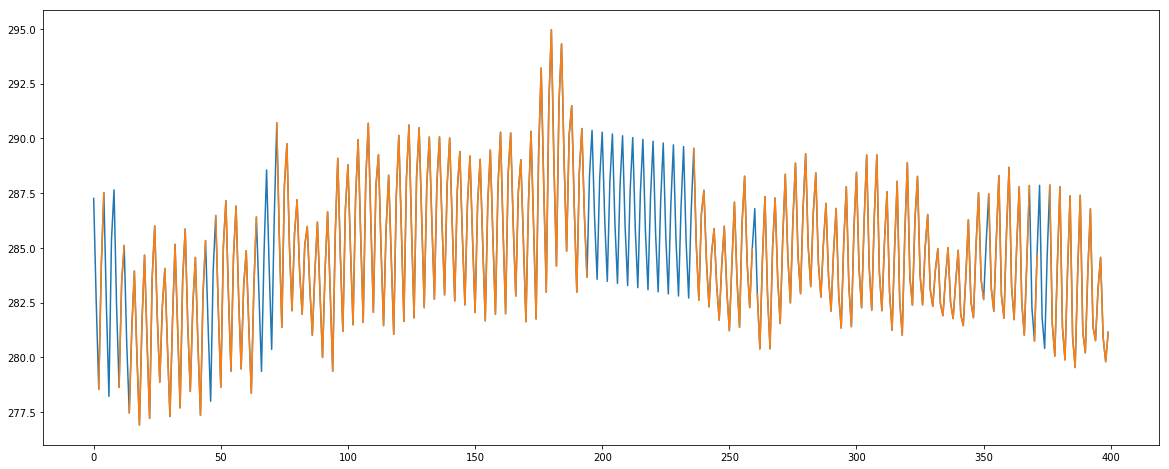

In [60]:
plt.rcParams['figure.figsize'] = [20, 8]
fill = np.mean(ds_temp_fill, axis=(1,2))
plt.plot(fill[time_ind][600:1000])
real = np.mean(ds_temp,axis=(1,2))
plt.plot(real[time_ind][600:1000])

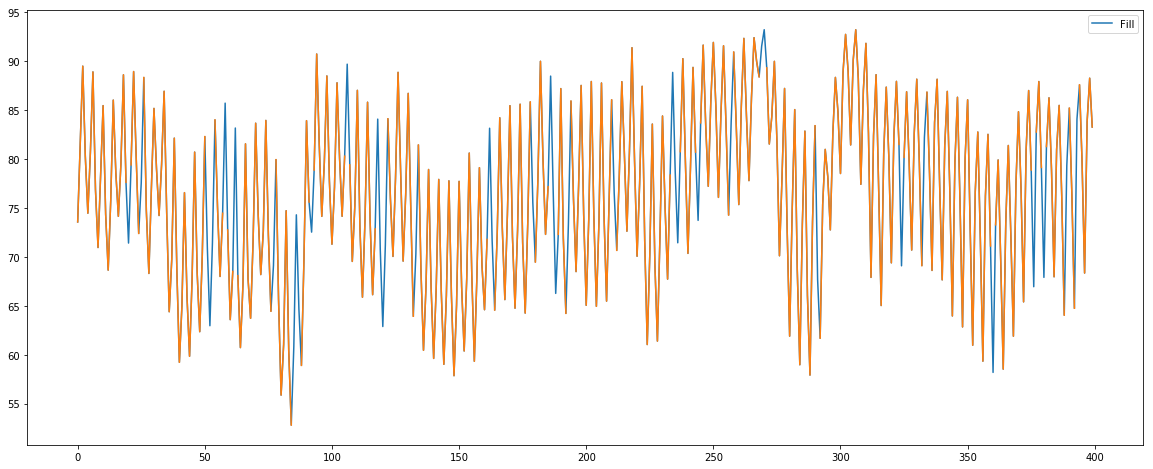

In [56]:
plt.rcParams['figure.figsize'] = [20, 8]
fill = np.mean(ds_humid_fill, axis=(1,2))
plt.plot(fill[time_ind][600:1000], label='Fill')
real = np.mean(ds_humid,axis=(1,2))
plt.plot(real[time_ind][600:1000])
plt.legend()

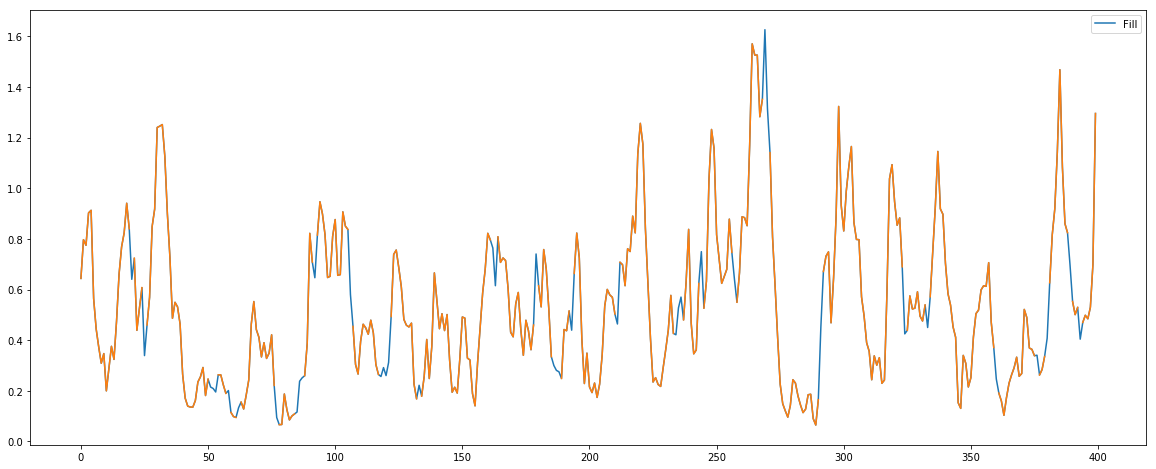

In [57]:
plt.rcParams['figure.figsize'] = [20, 8]
fill = np.mean(ds_precip_fill, axis=(1,2))
plt.plot(fill[time_ind][600:1000], label='Fill')
real = np.mean(ds_precip,axis=(1,2))
plt.plot(real[time_ind][600:1000])
plt.legend()

In [35]:
ds_temp_interp = np.array(ds3.temperature)[::3]

In [36]:
ds_humid_interp = np.array(ds3.humidity)[::3]
ds_percip_interp = np.array(ds3.precipitation)[2::3]

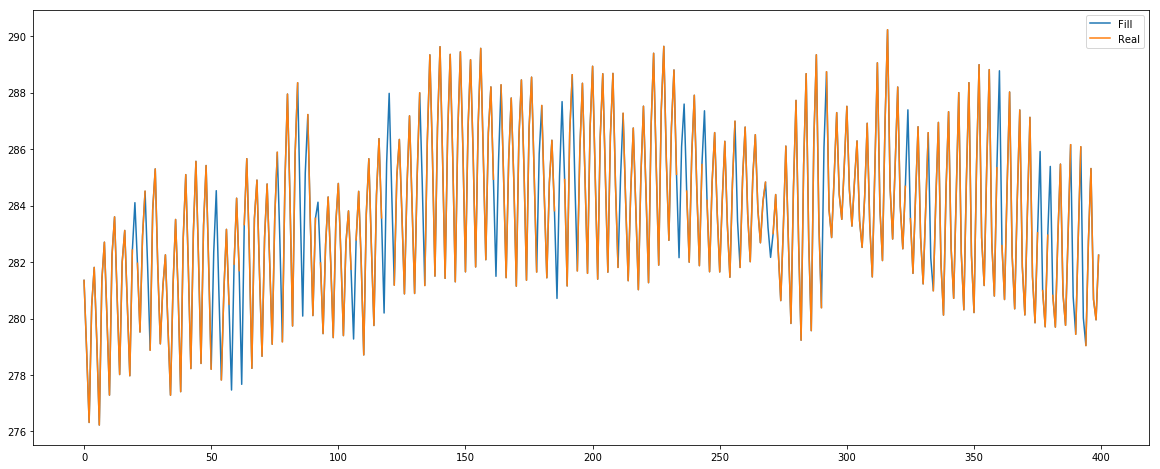

In [37]:
plt.rcParams['figure.figsize'] = [20, 8]
temp_fill_mean = np.mean(ds_temp_interp, axis=(1,2))
plt.plot(temp_fill_mean[time_ind][600:1000], label='Fill')
temp_real2 = np.mean(ds_temp, axis=(1,2))
plt.plot(temp_real2[time_ind][600:1000], label='Real')
plt.legend()

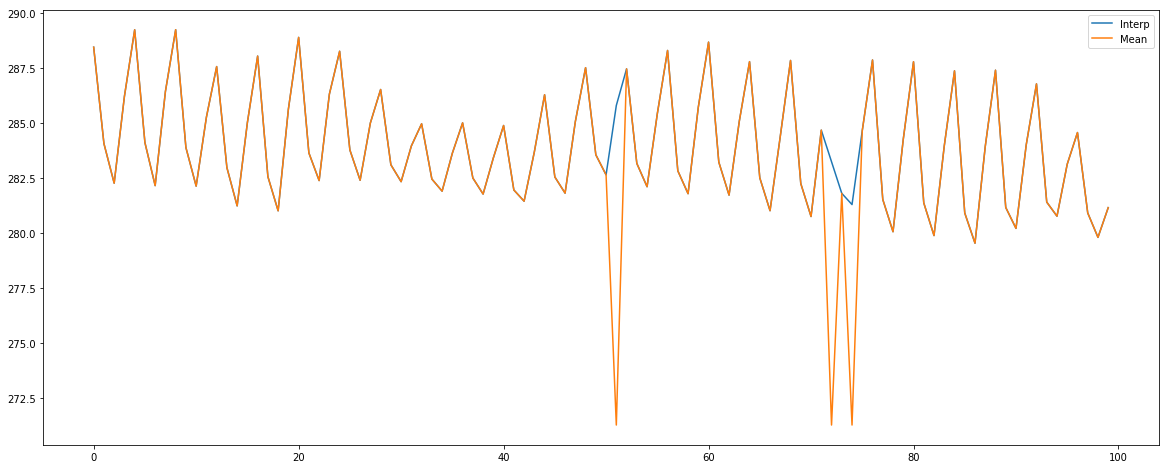

In [53]:
plt.rcParams['figure.figsize'] = [20, 8]
temp_fill_mean = np.mean(ds_temp_interp, axis=(1,2))
plt.plot(temp_fill_mean[time_ind][900:1000], label='Interp')
temp_real2 = np.mean(ds_temp_mean, axis=(1,2))
plt.plot(temp_real2[time_ind][900:1000], label='Mean')
plt.legend()

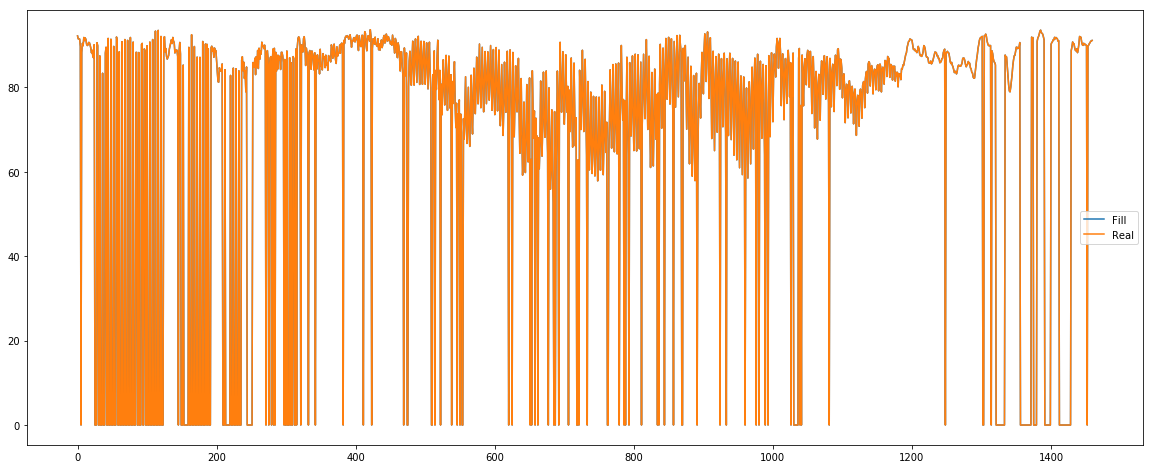

In [60]:
plt.rcParams['figure.figsize'] = [20, 8]
humid_fill_interp = np.mean(ds_humid_interp, axis=(1,2))
plt.plot(humid_fill_interp[time_ind], label='Fill')
humid = np.mean(ds_humid, axis=(1,2))
plt.plot(humid[time_ind], label='Real')

plt.legend()

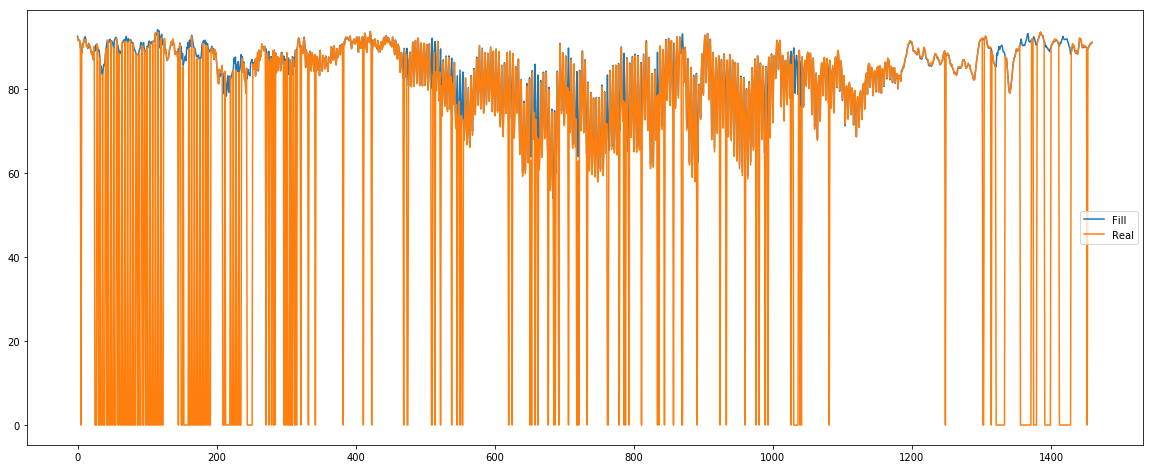

In [64]:
plt.rcParams['figure.figsize'] = [20, 8]
humid_fill_interp = np.mean(ds_humid_3, axis=(1,2))
plt.plot(humid_fill_interp[time_ind], label='Fill')
humid = np.mean(ds_humid, axis=(1,2))
plt.plot(humid[time_ind], label='Real')
plt.legend()

In [65]:
ds.close()
ds2.close()
ds3.close()
ds_3.close()

              T_K=1     T_K=2     T_K=3     T_K=4     T_K=5
---------  --------  --------  --------  --------  --------
Intercept  0.691679  0.953577  0.892844  0.754636  0.637247
num_det_0  0.70307   0.535665  0.476569  0.470542  0.478183


                 T_K=1        T_K=2       T_K=3        T_K=4        T_K=5
---------  -----------  -----------  ----------  -----------  -----------
Intercept   0.680715     0.938622     0.853934    0.698568     0.568825
num_det_0   0.671413     0.459619     0.343415    0.308596     0.327491
num_det_1   0.00186344  -0.0127985    0.022055    0.0772235    0.00932705
num_det_2  -0.0204804   -0.00129084   0.0801421   0.00172662   0.0640131
num_det_3   0.0209344    0.0969404    0.0258029   0.065711    -0.0126316
num_det_4   0.0556297   -0.00327041   0.0299633  -0.0351155    0.116688
num_det_5  -0.0120822    0.0260404   -0.0573152   0.10992     -0.00169864
num_det_6   0.0333196   -0.0563457    0.0911464  -0.0479986    0.00728933
num_det_7  -0.0907203    0.057423    -0.0232891   0.00539445   0.0866074
num_det_8   0.0962362   -0.00974706   0.0238602   0.116544     0.0643427
num_det_9   0.0359053    0.152231     0.171318    0.139449     0.109576


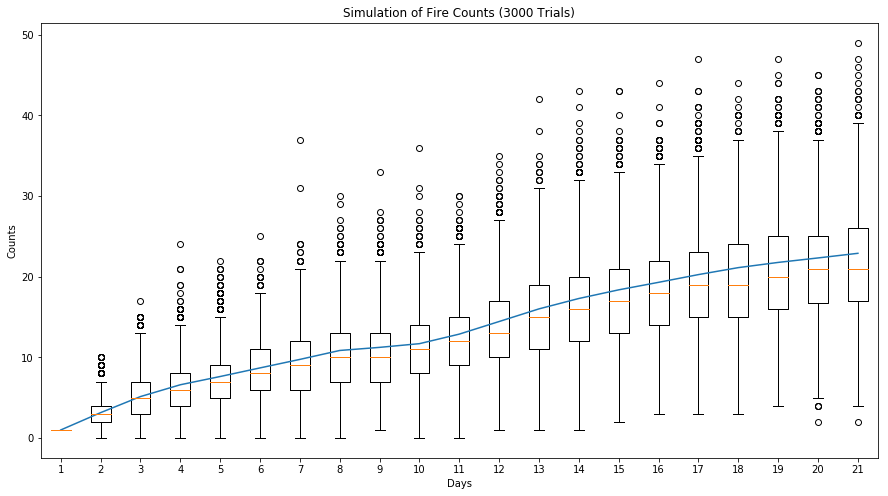

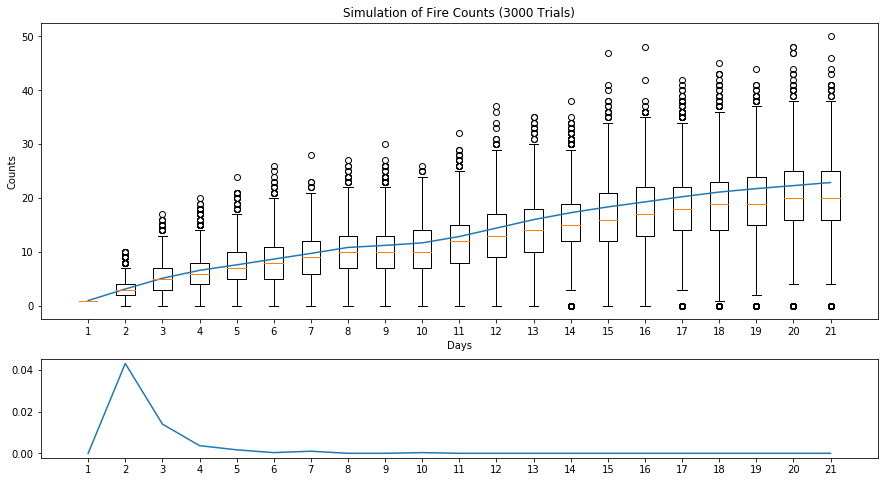

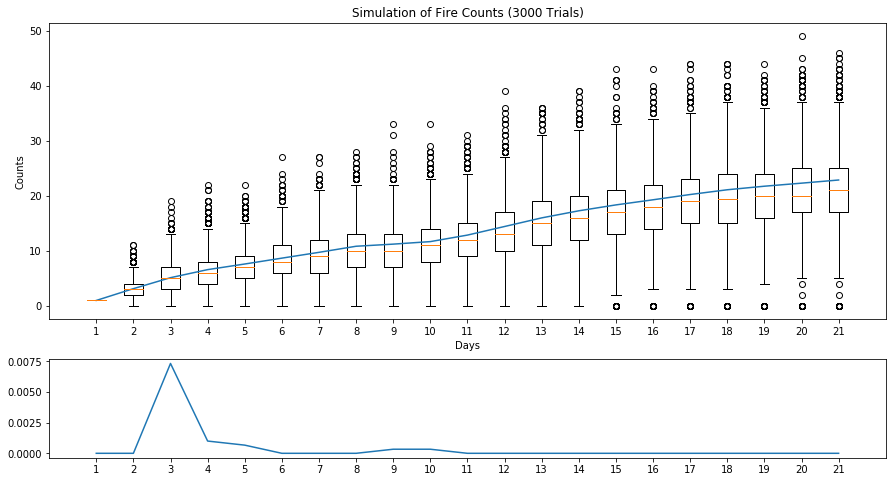

In [ ]:
results_active_only_grid, models_active_only_grid = evm.evaluate_model_params(model.active_only_grid_model_poisson, {'All' : ['temperature','humidity','wind','rain']}, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

In [226]:
# Regular act2
results_active_only_grid_act2, models_active_only_grid_act2 = evm.evaluate_model_params(lambda x: model.active_only_grid_model_poisson(x,active='active_2'), {'All' : ['temperature','humidity','wind','rain']}, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

 T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


In [227]:
# Try using +.1
results_active_only_grid_add, models_active_only_grid_add = evm.evaluate_model_params(lambda x: model.active_only_grid_model_poisson(x,active='active_2',log_shift=.1,log_correction='add'), {'All' : ['temperature','humidity','wind','rain']}, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


In [228]:
# Try using max() instead of +1 to prevent neg. inf on log of counts
reload(prg)
results_active_only_grid_max, models_active_only_grid_max = evm.evaluate_model_params(lambda x: model.active_only_grid_model_poisson(x,active='active_2',log_correction='max'), {'All' : ['temperature','humidity','wind','rain']}, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


In [229]:
# Try using max() instead of +1 to prevent neg. inf on log of counts
results_active_only_grid_max2, models_active_only_grid_max2 = evm.evaluate_model_params(lambda x: model.active_only_grid_model_poisson(x,active='active_2',log_shift=.5, log_correction='max'), {'All' : ['temperature','humidity','wind','rain']}, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


In [178]:
print models_active_only_grid_max['All'][0][0][0].summary()
print models_active_only_grid_max2['All'][0][0][0].summary()

                 Generalized Linear Model Regression Results                  
Dep. Variable:         num_det_target   No. Observations:                 6568
Model:                            GLM   Df Residuals:                     6562
Model Family:                 Poisson   Df Model:                            5
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -67925.
Date:                Thu, 17 May 2018   Deviance:                   1.1959e+05
Time:                        12:19:56   Pearson chi2:                 1.75e+05
No. Iterations:                     6                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.1247      0.312      0.400      0.689      -0.486     

In [ ]:
results_active_ig_grid, models_active_ig_grid = evm.evaluate_model_params(model.active_ig_grid_model_poisson, param_dict_grid, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

T_k=1 T_k=2 T_k=3


In [156]:
metrics_ = [metrics.root_mean_squared_error]
plt.rcParams['figure.figsize'] = [15, 8]

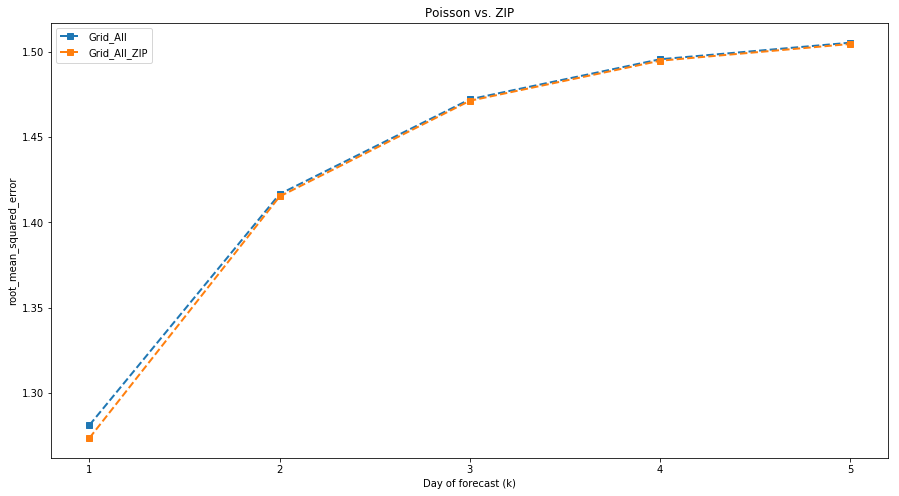

In [157]:
grid_max = {'Grid_All': results_active_grid_all[1]['Memory'], 'Grid_All_ZIP': results_active_grid_all_zip[1]['Memory']}
grid_max = vplt.plot_results_grid([(grid_max, 'Poisson vs. ZIP')], T_K_ARR, metrics_)

### Grid vs. Cluster

In [23]:
reload(gp)
results_no_ig_all, models_no_ig_all = evm.evaluate_model_params(model.no_ignition_model_poisson, {'All': ['temperature','humidity','wind','rain']}, X_active_dict, y_grid_dict, YEARS_TEST, T_K_ARR)
results_active_only_grid_all, models_active_only_grid_all = evm.evaluate_model_params(model.active_only_grid_model_poisson, {'All' : ['temperature','humidity','wind','rain']}, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

T_k=1 T_k=2 T_k=3 T_k=4 T_k=5
T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


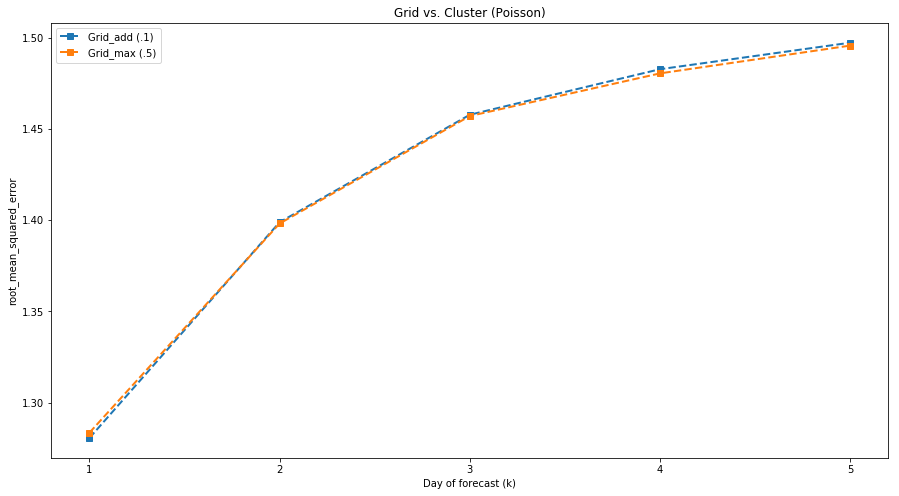

In [234]:
grid_max = {'Grid_add (.1)': results_active_only_grid_add[1]['All'], 'Grid_max (.5)': results_active_only_grid_max2[1]['All']}
grid_max = vplt.plot_results_grid([(grid_max, 'Grid vs. Cluster (Poisson)')], T_K_ARR, metrics_)

In [336]:
results_auto_grid, models_auto_grid = evm.evaluate_model_params(model.auto_grid_model, {'None': []}, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


In [340]:
reload(model)
results_active_only_grid, models_active_only_grid = evm.evaluate_model_params(model.active_only_grid_model_linear, {'All' : ['temperature','humidity','wind','rain']}, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


In [342]:
# Try using max() instead of +1 to prevent neg. inf on log of counts
results_active_only_grid_max3, models_active_only_grid_max2 = evm.evaluate_model_params(lambda x: model.active_only_grid_model_poisson(x,active='active_2',log_shift=.5, log_correction='max'), {'None' : []}, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)


T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


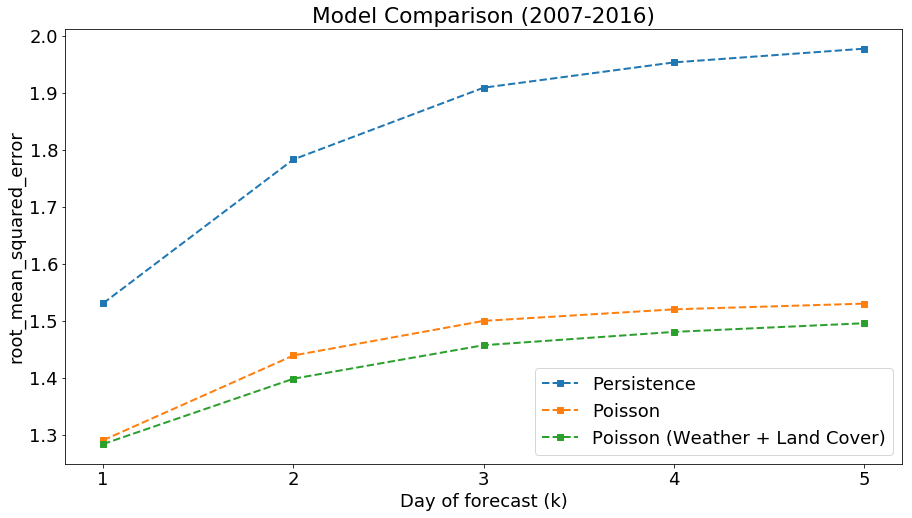

In [344]:
grid_max = {'Persistence': results_auto_grid[1]['None'], 'Poisson (Weather + Land Cover)': results_active_only_grid_max2[1]['All'], 'Poisson': results_active_only_grid_max3[1]['None']}
grid_max = vplt.plot_results_grid([(grid_max, 'Model Comparison (2007-2016)')], T_K_ARR, metrics_)

[0.7754817401709867, 0.82921471368078736, 0.87016726998771321, 0.88417361623036228, 0.89345421343348952]
[[0.63381737105460034, 0.29939968398843014, 2.5188152862915172, 0.86314452910129968, 0.39493496614035323, 0.33032517359350178, 1.3081753424825442, 0.52087110896985267, 2.3886533447836631, 0.96904771913119803], [0.80741443671860424, 0.31942178670720922, 2.6327602203361722, 0.96902977743282459, 0.39736992997760906, 0.3672436673950023, 1.4626085953891643, 0.59393356007684694, 2.6495918639942859, 1.0582161909305623], [0.83084197658032943, 0.33111890416153988, 2.7321679293052932, 0.9954155623577241, 0.3955098174769498, 0.38664242726909465, 1.5316357698209697, 0.61937079793239358, 2.7904028679825577, 1.0742598079442787], [0.86675430929665576, 0.34014517510114967, 2.7983458755319854, 0.99167478280743171, 0.40789312764477248, 0.37998337987747344, 1.5611852212729382, 0.63591126371917173, 2.8147144672315192, 1.0780366130109333], [0.85393945204908628, 0.34269169856339232, 2.8391433133384401, 1

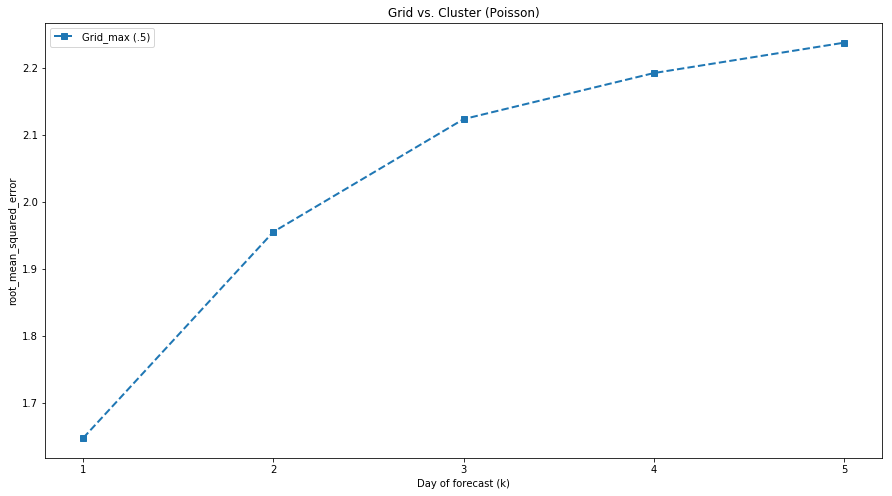

In [296]:


reload(vplt)
data = np.reshape(results_active_only_grid_max2[1]['All'], (5,2,33,55,10,110))
data = np.rollaxis(data, 4, 1)
grid_max = {'Grid_max (.5)': data}
grid_max = vplt.plot_results_grid_errorbars([(grid_max, 'Grid vs. Cluster (Poisson)')], T_K_ARR, metrics_)

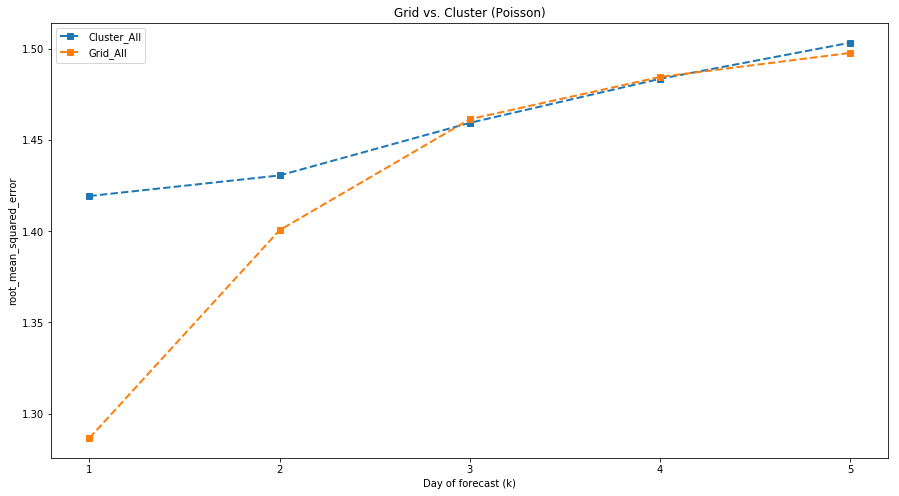

In [25]:

grid_vs_cluster_res = {'Cluster_All': results_no_ig_all[1]['All'], 'Grid_All': results_active_only_grid_all[1]['All']}
grid_vs_cluster = vplt.plot_results_grid([(grid_vs_cluster_res, 'Grid vs. Cluster (Poisson)')], T_K_ARR, metrics_)

In [42]:
results_no_ig_all, models_no_ig_all = evm.evaluate_model_params(model.no_ignition_model_poisson, {'All': ['temperature','humidity','wind','rain']}, X_active_dict, y_grid_dict, YEARS_TEST, T_K_ARR)
#results_active_only_grid_all, models_active_only_grid_all = evm.evaluate_model_params(active_only_grid_model_poisson, {'All' : ['temperature','humidity','wind','rain']}, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


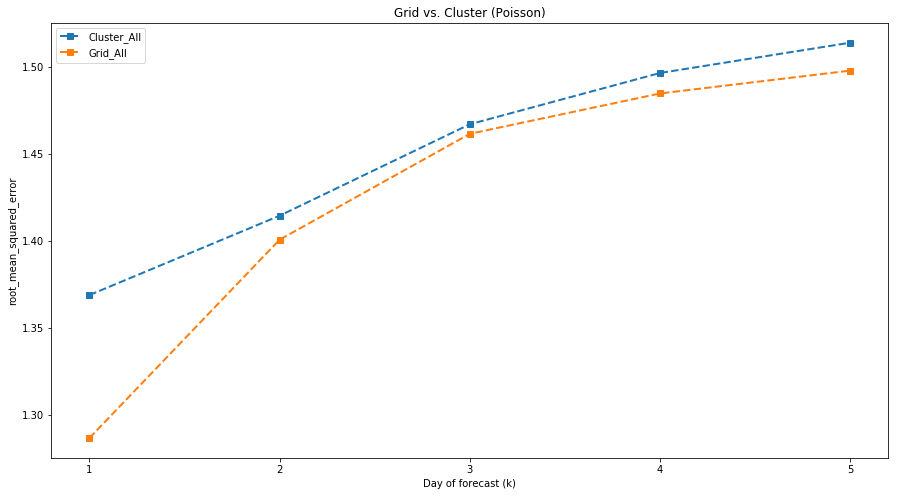

In [46]:
grid_vs_cluster_res = {'Cluster_All': results_no_ig_all[1]['All'], 'Grid_All': results_active_only_grid_all[1]['All']}
grid_vs_cluster = vplt.plot_results_grid([(model.grid_vs_cluster_res, 'Grid vs. Cluster (Poisson)')], T_K_ARR, metrics_)

### Unified vs. Separated

In [ ]:
results_no_ig_grid_all, models_no_ig_grid_all = evm.evaluate_model_params(model.no_ignition_grid_model_poisson, {'All' : ['temperature','humidity','wind','rain']}, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

In [ ]:
results_active_ig_grid_all, models_active_ig_grid_all = evm.evaluate_model_params(model.active_ig_grid_model_poisson,
                    {'All' : ['temperature','humidity','wind','rain']}, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

In [ ]:
uni_vs_sep_res = {'Unified_All': results_no_ig_grid_all[1]['All'],
                  'Separated_All': results_active_ig_grid_all[1]['All'],
                  'Active-Only_All': results_active_ig_grid_all[1]['All']}
uni_vs_sep = vplt.plot_results_grid([(uni_vs_sep_res, 'Unified vs. Separated vs. Active-Only (Poisson)')], T_K_ARR, metrics_)

### Adding Memory (Learned Weights)

In [34]:
params_mem_5 = ['temperature','humidity','wind','rain'] + ['num_det_' + str(i) for i in range(1,5)] + ['rain_' + str(i) for i in range(1,5)] + ['temperature_' + str(i) for i in range(1,5)]
params_mem_10 = ['temperature','humidity','wind','rain'] + ['num_det_' + str(i) for i in range(1,10)] + ['rain_' + str(i) for i in range(1,10)] + ['temperature_' + str(i) for i in range(1,10)]
param_dict_mem = {'All + Mem (5)': params_mem_5, 'All + Mem (10)': params_mem_10}
results_active_only_grid_all_mem, models_active_only_grid_all_mem = evm.evaluate_model_params(model.active_only_grid_model_poisson, param_dict_mem, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

 T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


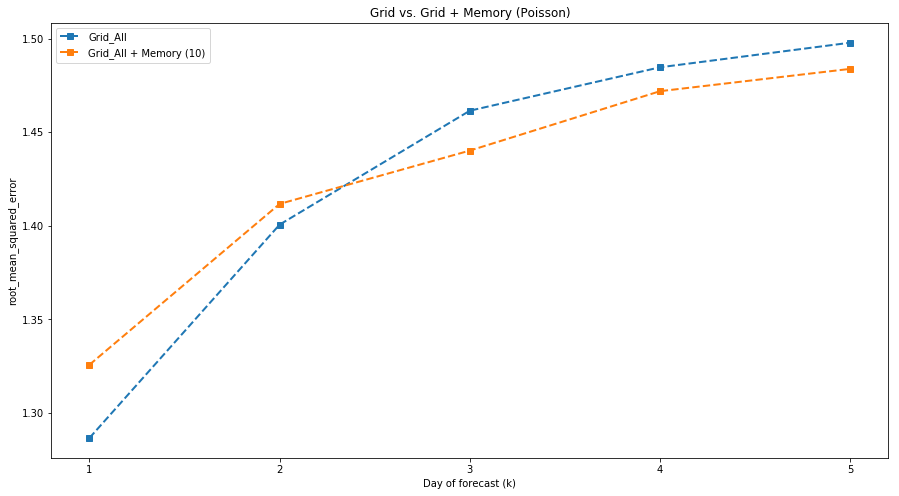

In [85]:
adding_mem_res = {'Grid_All': results_active_only_grid_all[1]['All'],
                  #'Grid_All + Memory (5)': results_active_only_grid_all_mem[1]['All + Mem (5)'],
                  'Grid_All + Memory (10)': results_active_only_grid_all_mem[1]['All + Mem (10)']}
adding_mem = vplt.plot_results_grid([(adding_mem_res, 'Grid vs. Grid + Memory (Poisson)')], T_K_ARR, metrics_)

### Adding Memory (Learned Weights) - Changing Active

In [81]:
results_active_only_grid_all_act_2, models_active_only_grid_all_act_2 = evm.evaluate_model_params(lambda x: model.active_only_grid_model_poisson(x,'active_2'), {'All': ['temperature','humidity','wind','rain']}, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

 T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


In [74]:
results_active_only_grid_all_mem_act_2, models_active_only_grid_all_mem = evm.evaluate_model_params(lambda x: model.active_only_grid_model_poisson(x,'active_2'), param_dict_mem, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


In [59]:
results_active_only_grid_all_mem_act_5, models_active_only_grid_all_mem = evm.evaluate_model_params(lambda x: model.active_only_grid_model_poisson(x,'active_5'), param_dict_mem, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)
results_active_only_grid_all_mem_act_10, models_active_only_grid_all_mem = evm.evaluate_model_params(lambda x: model.active_only_grid_model_poisson(x,'active_10'), param_dict_mem, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

T_k=1 T_k=2 T_k=3 T_k=4 T_k=5
T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


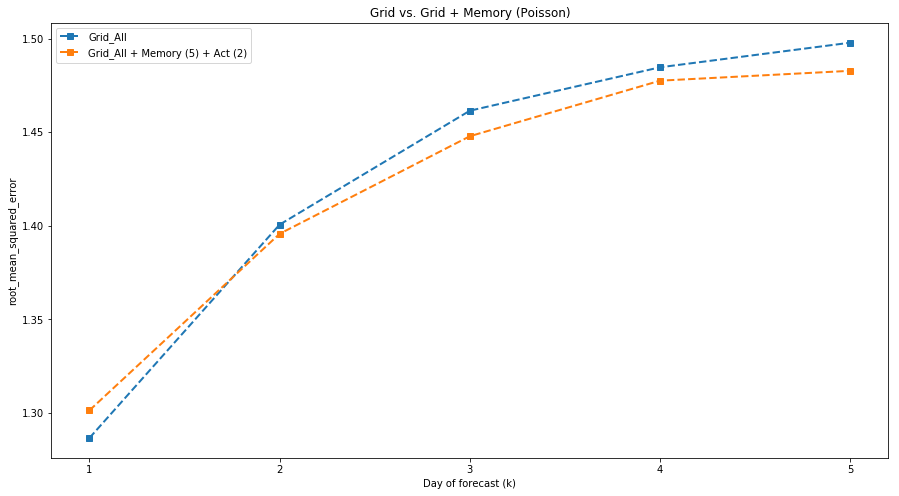

In [118]:
adding_mem_res = {'Grid_All': results_active_only_grid_all[1]['All'],
                  'Grid_All + Memory (5) + Act (2)': results_active_only_grid_all_mem_act_2[1]['All + Mem (5)'],
                  #'Grid_All + Act (2)': results_active_only_grid_all_act_2[1]['All'],
                  #'Grid_All + Memory (10) + Act (2)': results_active_only_grid_all_mem_act_2[1]['All + Mem (10)'],
                  #'Grid_All + Memory (5) + Act (5)': results_active_only_grid_all_mem_act_5[1]['All + Mem (5)'],
                  #'Grid_All + Memory (10) + Act (5)': results_active_only_grid_all_mem_act_5[1]['All + Mem (10)'],
                  #'Grid_All + Memory (5) + Act(10)': results_active_only_grid_all_mem_act_10[1]['All + Mem (5)'],
                  #'Grid_All + Memory (10) + Act(10)': results_active_only_grid_all_mem_act_10[1]['All + Mem (10)']
                 }
adding_mem = vplt.plot_results_grid([(adding_mem_res, 'Grid vs. Grid + Memory (Poisson)')], T_K_ARR, metrics_)

### Adding Memory (Expon. Decay)

In [49]:
params_dict_mem_expon = {}
for num,expon in enumerate([.25]):
    for expon_int in [10]:
        key = 'All + Expon Mem (%.2f, %d)' % (expon, expon_int)
        suffix = '_expon_%d_%d' % (num,expon_int)
        params_dict_mem_expon[key] = ['temperature','humidity','wind','rain'] + ['num_det' + suffix, 'rain' + suffix, 'temperature' + suffix] 

results_active_only_grid_all_mem_expon, models_active_only_grid_all_mem_expon = evm.evaluate_model_params(lambda x: model.active_only_grid_model_poisson(x,'active_2'), params_dict_mem_expon, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)


T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


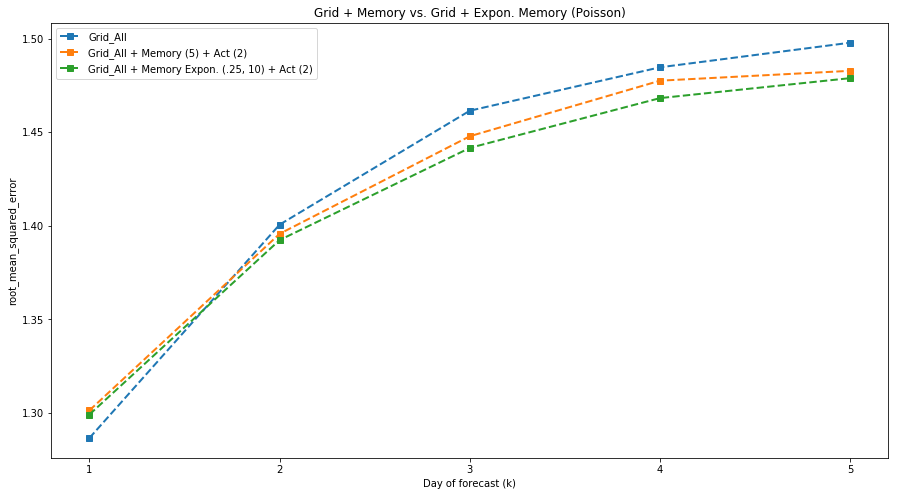

In [109]:
adding_mem_res = {#'Grid_All': results_active_only_grid_all[1]['All'],
                  #'Grid_All + Memory (5) + Act (2)': results_active_only_grid_all_mem_act_2[1]['All + Mem (5)'],
                  #'Grid_All + Expon. Memory (.25, 5) + Act (2)': results_active_only_grid_all_mem_expon[1]['All + Expon Mem (0.25, 5)'],
                  'Grid_All + Memory Expon. (.25, 10) + Act (2)': results_active_only_grid_all_mem_expon[1]['All + Expon Mem (0.25, 10)'],
                  #'Grid_All + Expon. Memory (.5, 5) + Act (2)': results_active_only_grid_all_mem_expon[1]['All + Expon Mem (0.50, 5)'],
                  #'Grid_All + Expon. Memory (.5, 10) + Act (2)': results_active_only_grid_all_mem_expon[1]['All + Expon Mem (0.50, 10)'],
                  #'Grid_All + Expon. Memory (.75, 5) + Act (2)': results_active_only_grid_all_mem_expon[1]['All + Expon Mem (0.75, 5)'],
                  #'Grid_All + Expon. Memory (.75, 10) + Act (2)': results_active_only_grid_all_mem_expon[1]['All + Expon Mem (0.75, 10)'],
                 }
adding_mem = vplt.plot_results_grid([(adding_mem_res, 'Grid + Memory vs. Grid + Expon. Memory (Poisson)')], T_K_ARR, metrics_)

### Adding Ground Cover Type

In [28]:
suffix = '_expon_%d_%d' % (0,10)
params = ['temperature','humidity','wind','rain'] + ['land_cover_%d' % i for i in range(0,land_cover.shape[2])] + ['num_det' + suffix, 'rain' + suffix, 'temperature' + suffix]
params_dict_land = {'All + Memory Expon. (.25,10) + Act (2) + Land': params}
results_active_only_grid_land, models_active_only_grid_land = evm.evaluate_model_params(lambda x: model.active_only_grid_model_poisson(x,'active_2'), params_dict_land, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


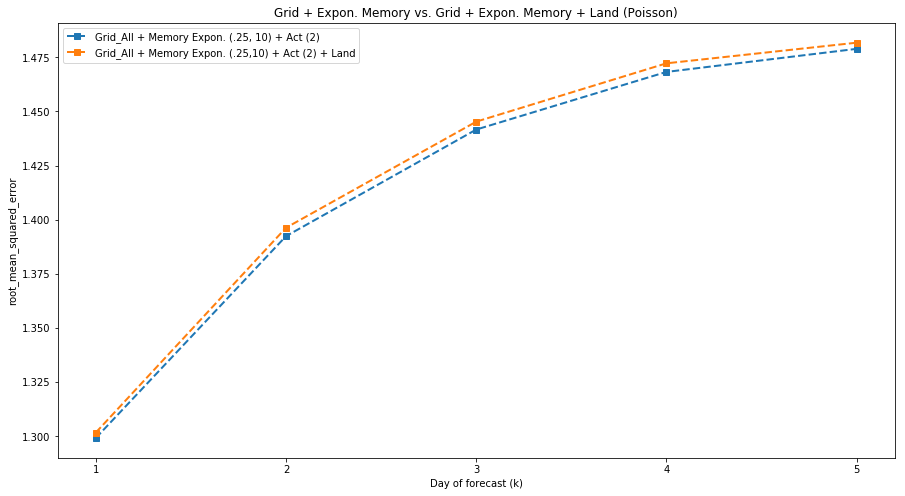

In [142]:
adding_mem_res = {#'Grid_All': results_active_only_grid_all[1]['All'],
                  'Grid_All + Memory Expon. (.25, 10) + Act (2)': results_active_only_grid_all_mem_expon[1]['All + Expon Mem (0.25, 10)'],
                  'Grid_All + Memory Expon. (.25,10) + Act (2) + Land': results_active_only_grid_land[1]['All + Memory Expon. (.25,10) + Act (2) + Land']
                 }
adding_mem = vplt.plot_results_grid([(adding_mem_res, 'Grid + Expon. Memory vs. Grid + Expon. Memory + Land (Poisson)')], T_K_ARR, metrics_)

In [47]:
models_active_only_grid_land['All + Memory Expon. (.25,10) + Act (2) + Land'][0][0][0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         num_det_target   No. Observations:                 9131
Model:                            GLM   Df Residuals:                     9109
Model Family:                 Poisson   Df Model:                           21
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -75530.
Date:                Fri, 20 Apr 2018   Deviance:                   1.3337e+05
Time:                        15:23:39   Pearson chi2:                 2.10e+05
No. Iterations:                    24                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.2699    319.335     -0.001      0.999    -626.154     625.614
np.log(num_det + 1)        0.6008      0.003    180.661      0.000       0.594       0.607
temperature                0.0103      0.001      7.885      0.000       0.008       0.013
humidity                  -0.0160      0.000    -46.286      0.000      -0.017      -0.015
wind                      -0.1448      0.003    -45.135      0.000      -0.151      -0.138
rain                      -0.0362      0.003    -12.526      0.000      -0.042      -0.031
land_cover_0              -0.0154      3.193     -0.005      0.996      -6.274       6.243
land_cover_1              -0.0110      3.193     -0.003      0.997      -6.270       6.248
land_cover_2            -2.83e-09   3.99e-06     -0.001      0.999   -7.83e-06    7.82e-06
land_cover_3             -22.5961   3.18e+04     -0.001      0.999   -6.24e+04    6.24e+04
land_cover_4              -0.1321      3.194     -0.041      0.967      -6.392       6.128
land_cover_5              -0.0199      3.193     -0.006      0.995      -6.279       6.239
land_cover_6            1.794e-08   2.53e-05      0.001      0.999   -4.95e-05    4.95e-05
land_cover_7              -0.0131      3.193     -0.004      0.997      -6.272       6.246
land_cover_8              -0.0122      3.193     -0.004      0.997      -6.271       6.247
land_cover_9              -0.0483      3.193     -0.015      0.988      -6.307       6.211
land_cover_10             -0.0119      3.193     -0.004      0.997      -6.271       6.247
land_cover_11             -0.1881      3.194     -0.059      0.953      -6.447       6.071
land_cover_12          -1.374e-11   2.82e-08     -0.000      1.000   -5.52e-08    5.52e-08
land_cover_13             -3.9107   3001.896     -0.001      0.999   -5887.519    5879.698
land_cover_14             -0.0671      3.194     -0.021      0.983      -6.326       6.192
land_cover_15             -0.0217      3.193     -0.007      0.995      -6.281       6.237
land_cover_16              0.0578      3.193      0.018      0.986      -6.201       6.317
num_det_expon_0_10         0.0397      0.001     27.720      0.000       0.037       0.042
rain_expon_0_10            0.0121      0.001      9.844      0.000       0.010       0.014
temperature_expon_0_10     0.0006      0.001      1.100      0.271      -0.000       0.002
==========================================================================================
"""

### Regularization

In [ ]:
suffix = '_expon_%d_%d' % (0,10)
params_expon_reg = ['temperature','humidity','wind','rain'] + ['num_det' + suffix, 'rain' + suffix, 'temperature' + suffix]
params_mem_10_reg = ['temperature','humidity','wind','rain'] + ['num_det_' + str(i) for i in range(1,10)] + ['rain_' + str(i) for i in range(1,10)] + ['temperature_' + str(i) for i in range(1,10)]
params_dict_reg = {'All + Memory Expon. (.25,10) + Act (2)': params_expon_reg,
                   'All + Memory (10) + Act (2)': params_mem_10_reg}
results_active_only_grid_reg_0, models_active_only_grid_reg_0 = evm.evaluate_model_params(lambda x: model.active_only_grid_model_poisson(x,'active_2',.01), params_dict_reg, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)
results_active_only_grid_reg_1, models_active_only_grid_reg_1 = evm.evaluate_model_params(lambda x: model.active_only_grid_model_poisson(x,'active_2',.1), params_dict_reg, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)
results_active_only_grid_reg_3, models_active_only_grid_reg_3 = evm.evaluate_model_params(lambda x: model.active_only_grid_model_poisson(x,'active_2',.5), params_dict_reg, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

 T_k=1 T_k=2 T_k=3 T_k=4 T_k=5
T_k=1 T_k=2 T_k=3 T_k=4

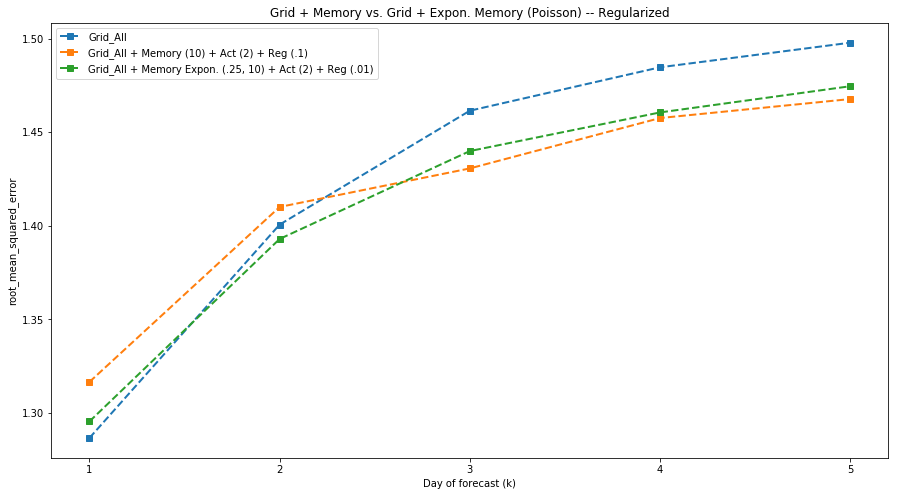

In [156]:
adding_mem_res = {'Grid_All': results_active_only_grid_all[1]['All'],
                  
                  #'Grid_All + Memory Expon. (.25, 10) + Act (2)': results_active_only_grid_all_mem_expon[1]['All + Expon Mem (0.25, 10)'],
                  #'Grid_All + Memory (10)': results_active_only_grid_all_mem[1]['All + Mem (10)'],
                  
                  'Grid_All + Memory Expon. (.25, 10) + Act (2) + Reg (.01)': results_active_only_grid_reg_0[1]['All + Memory Expon. (.25,10) + Act (2)'],
                  #'Grid_All + Memory (10) + Act (2) + Reg (.01)': results_active_only_grid_reg_0[1]['All + Memory (10) + Act (2)'],
                  #'Grid_All + Memory Expon. (.25, 10) + Act (2) + Reg (.1)': results_active_only_grid_reg_1[1]['All + Memory Expon. (.25,10) + Act (2)'],
                  'Grid_All + Memory (10) + Act (2) + Reg (.1)': results_active_only_grid_reg_1[1]['All + Memory (10) + Act (2)'],
                 }
adding_mem = vplt.plot_results_grid([(adding_mem_res, 'Grid + Memory vs. Grid + Expon. Memory (Poisson) -- Regularized')], T_K_ARR, metrics_)

In [30]:
suffix = '_expon_%d_%d' % (0,10)
params = ['temperature','humidity','wind','rain'] + ['land_cover_10'] + ['num_det' + suffix, 'rain' + suffix, 'temperature' + suffix]
params_dict_land = {'All + Memory Expon. (.25,10) + Act (2) + Land': params}
results_active_only_grid_land_grass, models_active_only_grid_land = evm.evaluate_model_params(lambda x: model.active_only_grid_model_poisson(x,'active_2'), params_dict_land, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


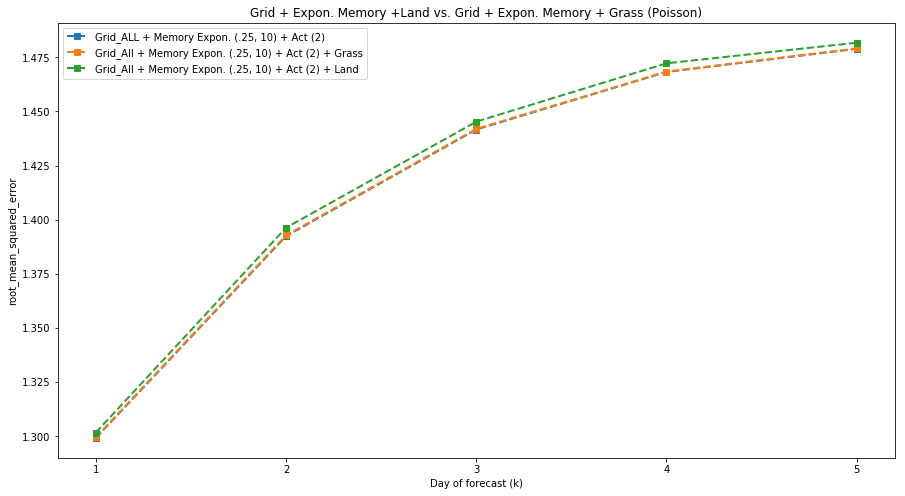

In [51]:
adding_mem_res = {#'Grid_All': results_active_only_grid_all[1]['All'],
                  'Grid_All + Memory Expon. (.25, 10) + Act (2) + Land': results_active_only_grid_land[1]['All + Memory Expon. (.25,10) + Act (2) + Land'],
                  'Grid_All + Memory Expon. (.25, 10) + Act (2) + Grass': results_active_only_grid_land_grass[1]['All + Memory Expon. (.25,10) + Act (2) + Land'],
                  'Grid_ALL + Memory Expon. (.25, 10) + Act (2)': results_active_only_grid_all_mem_expon[1]['All + Expon Mem (0.25, 10)']
                 }
adding_mem = vplt.plot_results_grid([(adding_mem_res, 'Grid + Expon. Memory +Land vs. Grid + Expon. Memory + Grass (Poisson)')], T_K_ARR, metrics_)

In [33]:
models_active_only_grid_land['All + Memory Expon. (.25,10) + Act (2) + Land'][0][0][0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         num_det_target   No. Observations:                 9131
Model:                            GLM   Df Residuals:                     9121
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -75748.
Date:                Fri, 20 Apr 2018   Deviance:                   1.3381e+05
Time:                        15:49:59   Pearson chi2:                 2.10e+05
No. Iterations:                     6                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1.9393      0.366     -5.305      0.000      -2.656      -1.223
np.log(num_det + 1)        0.6027      0.003    181.495      0.000       0.596       0.609
temperature                0.0109      0.001      8.389      0.000       0.008       0.013
humidity                  -0.0162      0.000    -47.310      0.000      -0.017      -0.016
wind                      -0.1478      0.003    -46.916      0.000      -0.154      -0.142
rain                      -0.0365      0.003    -12.674      0.000      -0.042      -0.031
land_cover_10             -0.0009      0.000     -2.107      0.035      -0.002   -6.41e-05
num_det_expon_0_10         0.0415      0.001     29.109      0.000       0.039       0.044
rain_expon_0_10            0.0108      0.001      8.906      0.000       0.008       0.013
temperature_expon_0_10     0.0009      0.001      1.688      0.091      -0.000       0.002
==========================================================================================
"""

[ 0.52371917  0.01594256]


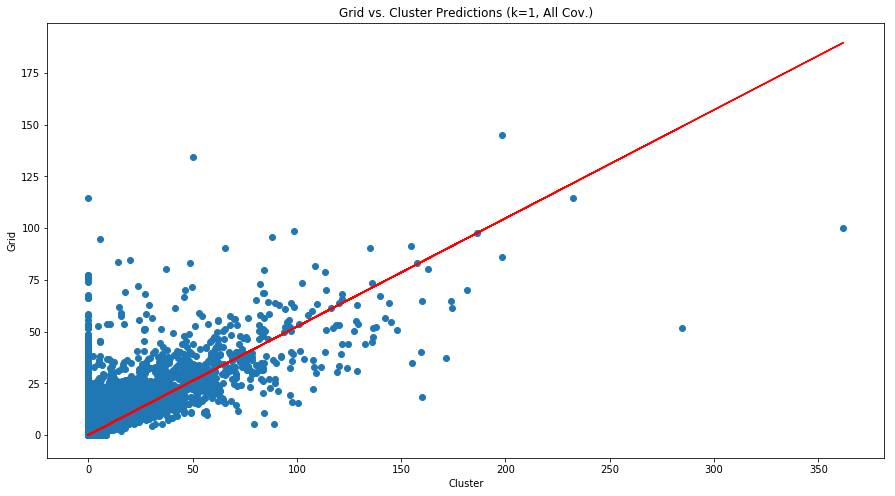

In [47]:
x = grid_vs_cluster_res['Cluster_All'][0][1].flatten()
y = grid_vs_cluster_res['Grid_All'][0][1].flatten()

fit = np.polyfit(x, y, deg=1)
_ = plt.plot(x, fit[0] * x + fit[1], color='red')
_ = plt.scatter(x, y)
plt.xlabel('Cluster')
plt.ylabel('Grid')
plt.title('Grid vs. Cluster Predictions (k=1, All Cov.)')
print fit

In [48]:
print np.mean(x), np.mean(y), np.mean(grid_vs_cluster_res['Cluster_All'][0][0].flatten()), np.mean(grid_vs_cluster_res['Grid_All'][0][0].flatten())

0.0426424292154 0.0382752221988 0.0468084147258 0.0468084147258


In [37]:
np.shape(results_active_only_grid[1]['All'][0][1])

(33, 55, 1100)

In [30]:
for i in range(110):
    print i, np.mean(results_active_only_grid[1]['All'][0][0][:,:,i])

0 0.0
1 0.0
2 0.000550964187328
3 0.0
4 0.000550964187328
5 0.0
6 0.00165289256198
7 0.00330578512397
8 0.00606060606061
9 0.0110192837466
10 0.0853994490358
11 0.0391184573003
12 0.0214876033058
13 0.00330578512397
14 0.0
15 0.00165289256198
16 0.000550964187328
17 0.00110192837466
18 0.00385674931129
19 0.000550964187328
20 0.00550964187328
21 0.00385674931129
22 0.00385674931129
23 0.0
24 0.0
25 0.000550964187328
26 0.00440771349862
27 0.00936639118457
28 0.00716253443526
29 0.0
30 0.0
31 0.00881542699725
32 0.0
33 0.00110192837466
34 0.00440771349862
35 0.0661157024793
36 0.100826446281
37 0.245179063361
38 0.0534435261708
39 0.0143250688705
40 0.00771349862259
41 0.00165289256198
42 0.0
43 0.00275482093664
44 0.0225895316804
45 0.0297520661157
46 0.036914600551
47 0.0110192837466
48 0.0159779614325
49 0.0677685950413
50 0.0964187327824
51 0.0793388429752
52 0.0848484848485
53 0.0842975206612
54 0.0589531680441
55 0.0953168044077
56 0.136639118457
57 0.0479338842975
58 0.0170798898

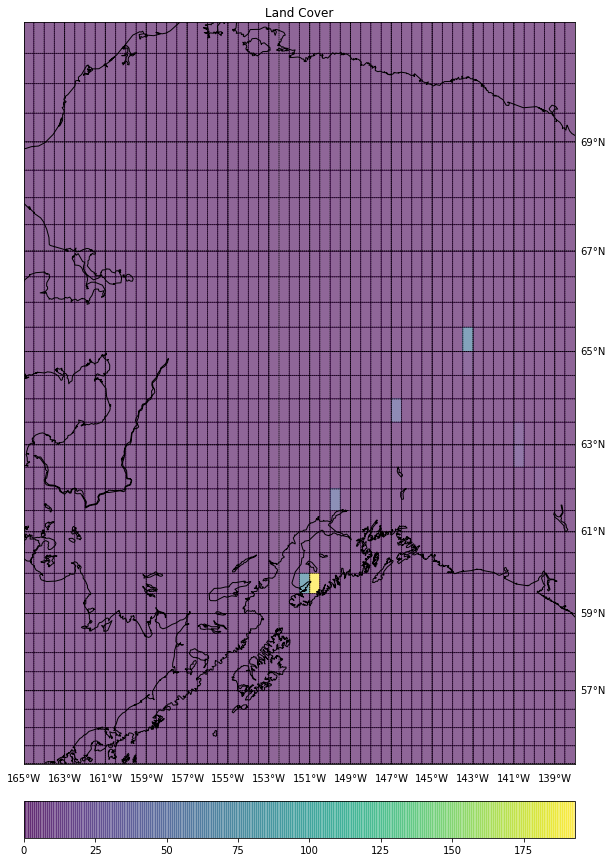

In [51]:
results_active_only_grid

mp = vmap.make_map(BOUNDING_BOX)
#mp.shadedrelief()

lats, lons = BOUNDING_BOX.make_grid()
values = results_active_only_grid[1]['All'][0][0][:,:,37]

cs = mp.pcolormesh(lons, lats , values, latlon=True, alpha=.6)
cbar = mp.colorbar(cs,location='bottom',pad="5%")

_ = plt.title('Land Cover')

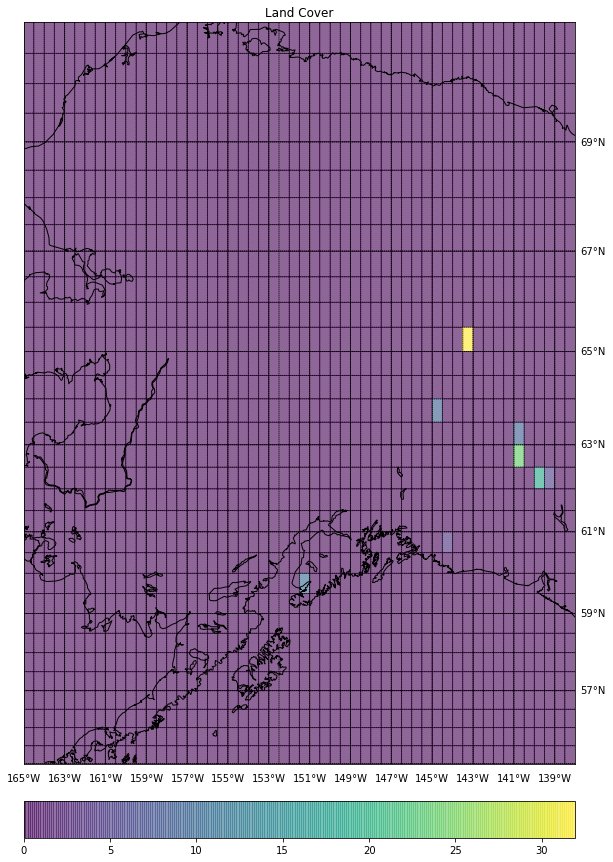

In [50]:
results_active_only_grid

mp = vmap.make_map(BOUNDING_BOX)
#mp.shadedrelief()

lats, lons = BOUNDING_BOX.make_grid()
values = results_active_only_grid[1]['All'][0][1][:,:,36]

cs = mp.pcolormesh(lons, lats , values, latlon=True, alpha=.6)
cbar = mp.colorbar(cs,location='bottom',pad="5%")

_ = plt.title('Land Cover')

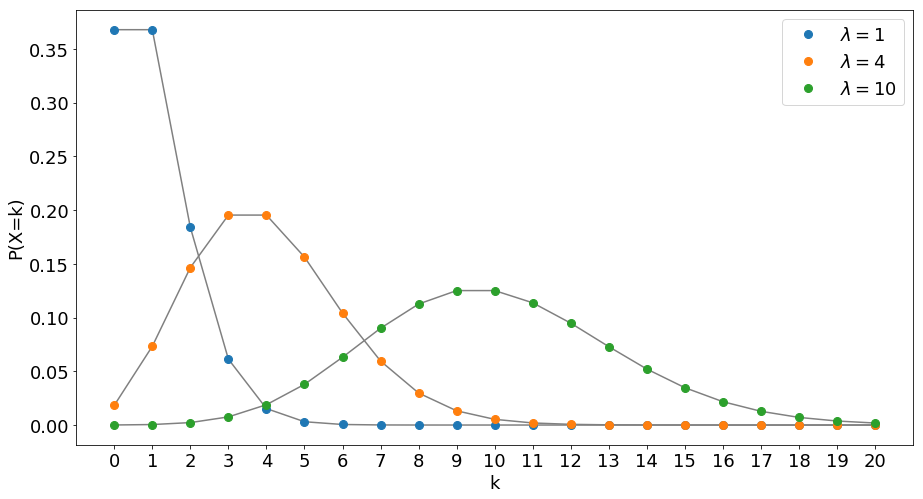

In [333]:
from scipy.stats import poisson
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
mu=1
fig, ax = plt.subplots(1, 1)
x = np.arange(21)
ax.plot(x, poisson.pmf(x, mu), color='gray', ms=8)
ax.plot(x, poisson.pmf(x, mu), 'o', ms=8, label='$\lambda = 1$')

mu=4
x = np.arange(21)
ax.plot(x, poisson.pmf(x, mu), color='gray', ms=8)
ax.plot(x, poisson.pmf(x, mu), 'o', ms=8, label='$\lambda = 4$')

mu=10
x = np.arange(21)
ax.plot(x, poisson.pmf(x, mu), color='gray', ms=8)
ax.plot(x, poisson.pmf(x, mu), 'o', ms=8, label='$\lambda = 10$')

_ = plt.xticks(x)
plt.xlabel('k')
plt.ylabel('P(X=k)')
plt.legend()
#ax.vlines(x, 0, poisson.pmf(x, mu), colors='b', lw=5, alpha=0.5)